In [0]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

# Load Dataset

In [26]:
# Confirmation, recovery, and death data sets by region worldwide
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Understanding the structure of the data set
# Data Set의 구조 파악
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
16946,2020-03-24,MS Zaandam,NaN,0.0,0.0,0,0.0,0
16947,2020-03-25,MS Zaandam,NaN,0.0,0.0,0,0.0,0
16948,2020-03-26,MS Zaandam,NaN,0.0,0.0,0,0.0,0
16949,2020-03-27,MS Zaandam,NaN,0.0,0.0,0,0.0,0
16950,2020-03-28,MS Zaandam,NaN,0.0,0.0,2,0.0,0


# Make it Simple

In [21]:
# Make Korea's confirmed cases timeseries dataframe
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South']

df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed])
df_korea =  pd.DataFrame(df_korea)

df_korea = df_korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_korea = df_korea.drop("index", axis=1)

# df_korea = df_korea.append([
#   {'date': pd.to_datetime('2020-03-22'), 'confirmed': 8,897}], ignore_index=True)

df_korea.tail()

,date,confirmed
62,2020-03-24,9037
63,2020-03-25,9137
64,2020-03-26,9241
65,2020-03-27,9332
66,2020-03-28,9478


# Plot

In [22]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [23]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
62,2020-03-24,9037
63,2020-03-25,9137
64,2020-03-26,9241
65,2020-03-27,9332
66,2020-03-28,9478


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [24]:
# Make Prophet model including daily seasonality
# Prophet에서 감안할 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

# Plot changepoints

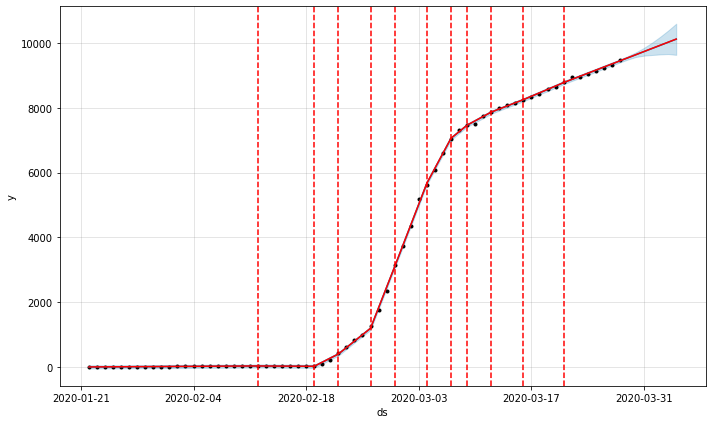

In [25]:
# display changepoints as red dotted line on the plot.
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)